In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os

In [2]:
# 데이터 불러오기. npz는 각 데이터는 wav_vals, label_vals로 이루어짐.
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [5]:
#라벨 데이터 처리.
#텍스트를 인덱스로 바꿈.
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] # 이외의 값들은 unknown, silence로 분류됨.

label_value = target_list #리스트 할당.
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value): # 리스트값 인덱스(0,1,2,3,4...), 리스트내의 값(yes, no, up....)
    new_label_value[l] = i # 텍스트를 키값으로, 숫자를 밸류값으로. {1: 'yes',.....}
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

#라벨값을 숫자로 바꿈
temp = [] #리스트. 
for v in speech_data["label_vals"]: #라벨값들.
    temp.append(label_value[v[0]]) # 그냥 v일 경우 ['~~']이므로 v[0]으로 내용물 꺼내기. label_value는 키값이 텍스트고, 밸류값이 인덱스이므로 인덱스 반환.
label_data = np.array(temp) #여기에 숫자로 된 라벨값들이 들어가 있음.

label_data

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


array([ 3,  3,  3, ..., 11, 11, 11])

In [6]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")
#1차원 Waveform -> 2차원 Spectrogram

✅


In [7]:
spec_data=[]
data = speech_data["wav_vals"]
for wav in data: 
    stft = wav2spec(wav)
    spec_data.append(stft)
spec_data = np.array(spec_data)
spec_data.shape

(50620, 130, 126)

In [8]:
from sklearn.model_selection import train_test_split
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(spec_data, #스피치값, 라벨을 0.1 비율로 섞어서 각각 train, test에 넣기
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
train_wav = train_wav[:27000]
test_wav = test_wav[:3000]
train_label = train_label[:27000]
test_label = test_label[:3000]

#train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN 원래형태가 (분배된 갯수, sr)인데 (분배된 갯수, sr, 1)로 차원 추가.
#test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

✅


In [9]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (27000, 130, 126)
train labels :  (27000,)
test data :  (3000, 130, 126)
test labels :  (3000,)
✅


In [18]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac19/aiffel/speech_recognition/models/wav'

In [19]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [20]:
import tensorflow as tf
del speech_data
del spec_data
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")


NameError: name 'speech_data' is not defined

In [26]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav= tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 130, 32)           36320     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 65, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 65, 64)            18496     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 32, 64)            0   

In [27]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [28]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [29]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
837/843 [============================>.] - ETA: 0s - loss: 1.8728 - accuracy: 0.3527
Epoch 00001: val_loss improved from inf to 1.50575, saving model to /home/ssac19/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 5s 6ms/step - loss: 1.8715 - accuracy: 0.3536 - val_loss: 1.5057 - val_accuracy: 0.4859
Epoch 2/10
836/843 [============================>.] - ETA: 0s - loss: 1.3389 - accuracy: 0.5404
Epoch 00002: val_loss improved from 1.50575 to 1.13638, saving model to /home/ssac19/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 5s 6ms/step - loss: 1.3391 - accuracy: 0.5399 - val_loss: 1.1364 - val_accuracy: 0.6028
Epoch 3/10
839/843 [============================>.] - ETA: 0s - loss: 1.0503 - accuracy: 0.6450
Epoch 00003: val_loss improved from 1.13638 to 0.87585, saving model to /home/ssac19/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 5s 6ms/step - loss: 1.0508 - a

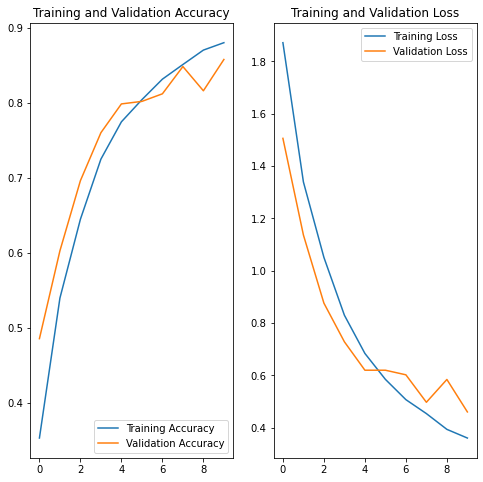

✅


In [30]:
# train_loss와 val_loss의 차이가 커지면 오버피팅
# Conv1D기반의 간단한 분류모델
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [31]:
#모델을 컴파일할때 저장하라고 세팅했던 weight불러오기.
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [32]:
#test data를 통해 검증
results = model_wav.evaluate(test_dataset)
print("✅")

188/188 [==============================] - 21s 112ms/step - loss: 0.4757 - accuracy: 0.8460
✅


In [33]:
# loss는 소수점 3자리까지, 정확도는 퍼센트로 바꾸고 소수점 4자리까지.
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.476
accuracy value: 84.6000%
✅


In [34]:
#skip-connection
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 130, 32)      36320       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 130, 32)      9248        conv1d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 65, 32)       0           conv1d_31[0][0]                  
____________________________________________________________________________________________

In [35]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [36]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [37]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
837/843 [============================>.] - ETA: 0s - loss: 1.9654 - accuracy: 0.3301
Epoch 00001: val_loss improved from inf to 1.55237, saving model to /home/ssac19/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 1.9633 - accuracy: 0.3309 - val_loss: 1.5524 - val_accuracy: 0.4798
Epoch 2/10
837/843 [============================>.] - ETA: 0s - loss: 1.3674 - accuracy: 0.5392
Epoch 00002: val_loss improved from 1.55237 to 1.14032, saving model to /home/ssac19/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 5s 6ms/step - loss: 1.3666 - accuracy: 0.5393 - val_loss: 1.1403 - val_accuracy: 0.6095
Epoch 3/10
843/843 [==============================] - ETA: 0s - loss: 1.0506 - accuracy: 0.6455
Epoch 00003: val_loss improved from 1.14032 to 0.91776, saving model to /home/ssac19/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 1.0506 - a

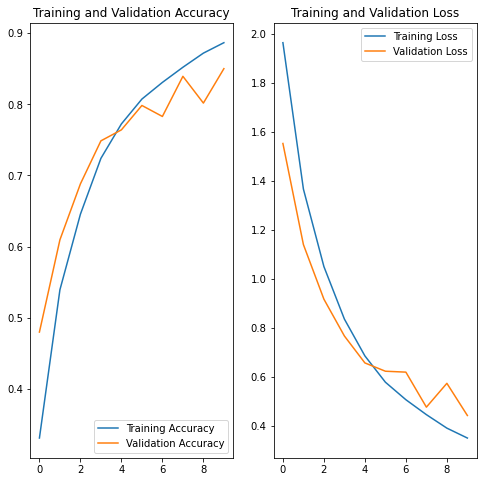

✅


In [38]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [39]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

188/188 [==============================] - 6s 30ms/step - loss: 0.4485 - accuracy: 0.8433
loss value: 0.448
accuracy value: 84.3333%
✅
